## Source

### http://csbdeep.bioimagecomputing.com/examples/denoising2D_probabilistic/

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import skimage
from skimage import external
from skimage.external import tifffile
from skimage import data, img_as_float
from skimage import exposure
from skimage.transform import rescale, resize, downscale_local_mean

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

In [3]:
def train_test_val(folder_path, channels = 1, train_pp = .6, test_pp = .2, val_pp = .2, set_seed = 1):
    #check to make sure percentages equal 1
    if train_pp+test_pp+val_pp != 1:
        raise Exception("train, test, val percentages must equal 1")
    
    #check to make sure channels in 1-5
    for c in list((channels,6)):
        if c not in list(range(1,7)):
            raise Exception("channels can only be in range 1-5")
    
    #Find file paths
    for root, dirs, files in os.walk(folder_path):
        root_path = root
        root_dir = dirs
        root_files = files
    
    #split each file to find relevant numbers
    sample_zplanes_folder = []
    for file in root_files:
        s,c,z = file.split('_')
        s_n = s.strip('sample')
        c_n = c.strip('channel')
        z_n = z.strip('z').split('.')[0]
        #create new entries where first part of key is sample #
        #second part of key is zplane #
        entry = list([str(s_n)+str('_')+str(z_n), file])
        sample_zplanes_folder.append(entry)
    
    #create dictionary with new keys for sample # and zplane #
    d = defaultdict(list)
    for key, entry in sample_zplanes_folder:
        d[key].append(entry)
    
    #full dictionary of files with corresponding sample/zplane #
    samples = d
    #just sample/zplane keys used to split data
    samples_list = list(samples.keys())


    #set number entries base on pp's for train, test, val
    train_p, test_p, val_p = round((len(samples_list))*train_pp), \
                             round((len(samples_list))*test_pp), \
                             round((len(samples_list))*val_pp)

    #set train seed
    np.random.seed(set_seed)
    #select training set
    train = list(np.random.choice(samples_list, size=train_p, replace=False))
    #remove training set from original list
    samples_list = list(set(samples_list) - set(train))

    #set test seed
    np.random.seed(set_seed)
    #select training set
    test = list(np.random.choice(samples_list, size=test_p, replace=False))
    #remove training set from original list
    val = list(set(samples_list) - set(test))
    
    #set channel list
    channel_set = list((channels,6))
    
    #training data
    train_paths = []
    for t in train:
        entry = samples[t]
        train_paths.append(entry)

    train_final = []
    for file in train_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        train_final.append(sorted(temp))  

    #test data
    test_paths = []
    for t in test:
        entry = samples[t]
        test_paths.append(entry)

    test_final = []
    for file in test_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        test_final.append(sorted(temp)) 

    #validation data 
    val_paths = []
    for t in val:
        entry = samples[t]
        val_paths.append(entry)

    val_final = []
    for file in val_paths:
        temp = []
        for channel_file in file:
            s,c,z = channel_file.split('_')
            c_n = c.strip('channel')
            for c in channel_set:
                if c_n == str(c):
                    temp.append(str(root_path)+str(channel_file))
        val_final.append(sorted(temp))
    
    return(train_final, test_final, val_final)

In [4]:
folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/'

In [5]:

train, test, val = train_test_val(folder_path, \
                                  channels = 1, \
                                  train_pp = .6, \
                                  test_pp = .2, \
                                  val_pp = .2, \
                                  set_seed = 1)

In [6]:
train

[['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel1_z3.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample31_channel6_z3.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel1_z2.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample111_channel6_z2.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample2_channel1_z7.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample2_channel6_z7.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample97_channel1_z75.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample97_channel6_z75.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample119_channel1_z10.tif',
  '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample119_channel6_z10.tif'],
 ['/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample116_channel1_z30.tif',
  '/gpfs/data/lionn

In [7]:
#read in X train
X = []
for i in range(0,len(train)):
    entry = skimage.external.tifffile.imread(train[i][0])
    X.append(entry)
    
X = np.array(X)

#read in X val
X_val = []
for i in range(0,len(val)):
    entry = skimage.external.tifffile.imread(val[i][0])
    X_val.append(entry)
    
X_val = np.array(X_val)

#read in X test
X_test = []
for i in range(0,len(test)):
    entry = skimage.external.tifffile.imread(test[i][0])
    X_test.append(entry)
    
X_test = np.array(X_test)


In [8]:
#read in Y train
Y = []
for i in range(0,len(train)):
    entry = skimage.external.tifffile.imread(train[i][1])
    Y.append(entry)
    
Y = np.array(Y)

#read in Y val
Y_val = []
for i in range(0,len(val)):
    entry = skimage.external.tifffile.imread(val[i][1])
    Y_val.append(entry)
    
Y_val = np.array(Y_val)

#read in Y test
Y_test = []
for i in range(0,len(test)):
    entry = skimage.external.tifffile.imread(test[i][1])
    Y_test.append(entry)
    
Y_test = np.array(Y_test)

In [9]:
#find new exposure scale

#create joint stack
ALL_IMGS = np.vstack((X,X_val,X_test,Y,Y_val,Y_test))

#find minimum intensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_min = ALL_IMGS[i].min()
        
    else:
        if ALL_IMGS[i].min() < stack_min:
            stack_min = ALL_IMGS[i].min()
        else: 
            stack_min = stack_min

#find maximum instensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_max = ALL_IMGS[i].max()
        
    else:
        if ALL_IMGS[i].max() > stack_max:
            stack_max = ALL_IMGS[i].max()
        else: 
            stack_max = stack_max

In [10]:
#rescale exposure intensity for all images 
#resize images --> 512 to 128 

#X train
X_TRAIN = []
for i in range(0,len(X)):
    image = exposure.rescale_intensity(X[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_TRAIN.append(image)
X_TRAIN = np.array(X_TRAIN)
    
#X val
X_VAL = []
for i in range(0,len(X_val)):
    image = exposure.rescale_intensity(X_val[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_VAL.append(image)
X_VAL = np.array(X_VAL)

#X test
X_TEST = []
for i in range(0,len(X_test)):
    image = exposure.rescale_intensity(X_test[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    X_TEST.append(image)
X_TEST = np.array(X_TEST)

#Y train
Y_TRAIN = []
for i in range(0,len(Y)):
    image = exposure.rescale_intensity(Y[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_TRAIN.append(image)
Y_TRAIN = np.array(Y_TRAIN)
    
#Y val
Y_VAL = []
for i in range(0,len(Y_val)):
    image = exposure.rescale_intensity(Y_val[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_VAL.append(image)
Y_VAL = np.array(Y_VAL)

#Y test
Y_TEST = []
for i in range(0,len(Y_test)):
    image = exposure.rescale_intensity(Y_test[i],in_range=(stack_min,stack_max))
    image = rescale(image, 1.0/4.0, anti_aliasing=False)
    Y_TEST.append(image)
Y_TEST = np.array(Y_TEST)

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
print(X_TRAIN.shape)
print(X_VAL.shape)
print(X_TEST.shape)
print(Y_TRAIN.shape)
print(Y_VAL.shape)
print(Y_TEST.shape)

(3886, 128, 128)
(1295, 128, 128)
(1295, 128, 128)
(3886, 128, 128)
(1295, 128, 128)
(1295, 128, 128)


In [12]:
#reshape X and Y --> (3886, 512, 512) to (3886, 512, 512, 1)

X_TRAIN = X_TRAIN.reshape(3886, 128, 128,1)
X_VAL = X_VAL.reshape(1295, 128, 128,1)
X_TEST = X_TEST.reshape(1295, 128, 128,1)
Y_TRAIN = Y_TRAIN.reshape(3886, 128, 128,1)
Y_VAL = Y_VAL.reshape(1295, 128, 128,1)
Y_TEST = Y_TEST.reshape(1295, 128, 128,1)



In [13]:
#original set (not rescaled, not resized)

#reshape X and Y --> (3886, 512, 512) to (3886, 512, 512, 1)

X = X.reshape(3886, 512, 512,1)
X_val = X_val.reshape(1295, 512, 512,1)
X_test = X_test.reshape(1295, 512, 512,1)
Y = Y.reshape(3886, 512, 512,1)
Y_val = Y_val.reshape(1295, 512, 512,1)
Y_test = Y_test.reshape(1295, 512, 512,1)

In [14]:
#Image Axes
#X: columns, Y: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)
axes = 'SYXC'

c = axes_dict(axes)['C']
n_channel_in,n_channel_out = X_TRAIN.shape[c], Y_TRAIN.shape[c]


In [15]:
#set config file
config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

In [16]:
#create model
hn_model = CARE(config, 'hn_model', basedir='models')

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /gpfs/home/hln240/models/hn_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [17]:
#history
hn_history = hn_model.train(X_TRAIN,Y_TRAIN, validation_data=(X_VAL,Y_VAL))

Epoch 1/100
30/30 [==============================] - 4s 139ms/step - loss: -0.0129 - mse: 0.0045 - mae: 0.0502 - val_loss: -0.7152 - val_mse: 0.0023 - val_mae: 0.0432
Epoch 2/100
30/30 [==============================] - 2s 54ms/step - loss: -0.6757 - mse: 0.0037 - mae: 0.0504 - val_loss: -0.3783 - val_mse: 0.0068 - val_mae: 0.0733
Epoch 3/100
30/30 [==============================] - 2s 53ms/step - loss: -0.5586 - mse: 0.0026 - mae: 0.0405 - val_loss: 0.0491 - val_mse: 0.0021 - val_mae: 0.0409
Epoch 4/100
30/30 [==============================] - 2s 53ms/step - loss: -0.2720 - mse: 0.0018 - mae: 0.0316 - val_loss: -0.9883 - val_mse: 0.0017 - val_mae: 0.0275
Epoch 5/100
30/30 [==============================] - 2s 53ms/step - loss: -1.3965 - mse: 0.0015 - mae: 0.0293 - val_loss: -2.0374 - val_mse: 0.0010 - val_mae: 0.0203
Epoch 6/100
30/30 [==============================] - 2s 70ms/step - loss: -1.9662 - mse: 0.0011 - mae: 0.0230 - val_loss: -1.7874 - val_mse: 9.7985e-04 - val_mae: 0.0258


30/30 [==============================] - 2s 54ms/step - loss: -3.2726 - mse: 1.0557e-04 - mae: 0.0073 - val_loss: -2.7226 - val_mse: 1.4213e-04 - val_mae: 0.0101
Epoch 49/100
30/30 [==============================] - 2s 53ms/step - loss: -3.1521 - mse: 1.1317e-04 - mae: 0.0078 - val_loss: -3.2114 - val_mse: 1.1482e-04 - val_mae: 0.0077
Epoch 50/100
30/30 [==============================] - 2s 53ms/step - loss: -3.2668 - mse: 9.9912e-05 - mae: 0.0072 - val_loss: -3.4019 - val_mse: 9.8184e-05 - val_mae: 0.0065
Epoch 51/100
30/30 [==============================] - 2s 54ms/step - loss: -3.4093 - mse: 8.9978e-05 - mae: 0.0065 - val_loss: -3.2652 - val_mse: 9.7855e-05 - val_mae: 0.0070
Epoch 52/100
30/30 [==============================] - 2s 54ms/step - loss: -3.3038 - mse: 9.3945e-05 - mae: 0.0069 - val_loss: -3.1312 - val_mse: 1.0343e-04 - val_mae: 0.0081
Epoch 53/100
30/30 [==============================] - 2s 54ms/step - loss: -3.2984 - mse: 9.8444e-05 - mae: 0.0070 - val_loss: -3.6941 - v

Epoch 94/100
30/30 [==============================] - 2s 53ms/step - loss: -3.8059 - mse: 4.9158e-05 - mae: 0.0046 - val_loss: -3.9471 - val_mse: 4.8152e-05 - val_mae: 0.0043
Epoch 95/100
30/30 [==============================] - 2s 53ms/step - loss: -3.9771 - mse: 4.5233e-05 - mae: 0.0042 - val_loss: -4.0014 - val_mse: 4.8254e-05 - val_mae: 0.0042
Epoch 96/100
30/30 [==============================] - 2s 53ms/step - loss: -4.0176 - mse: 4.0202e-05 - mae: 0.0040 - val_loss: -3.9521 - val_mse: 5.0163e-05 - val_mae: 0.0044
Epoch 97/100
30/30 [==============================] - 2s 54ms/step - loss: -3.9204 - mse: 4.6536e-05 - mae: 0.0044 - val_loss: -3.9936 - val_mse: 4.8157e-05 - val_mae: 0.0042
Epoch 98/100
30/30 [==============================] - 2s 54ms/step - loss: -3.8953 - mse: 4.8693e-05 - mae: 0.0045 - val_loss: -3.9620 - val_mse: 4.8384e-05 - val_mae: 0.0043
Epoch 99/100
30/30 [==============================] - 2s 54ms/step - loss: -3.9381 - mse: 4.6674e-05 - mae: 0.0043 - val_loss

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


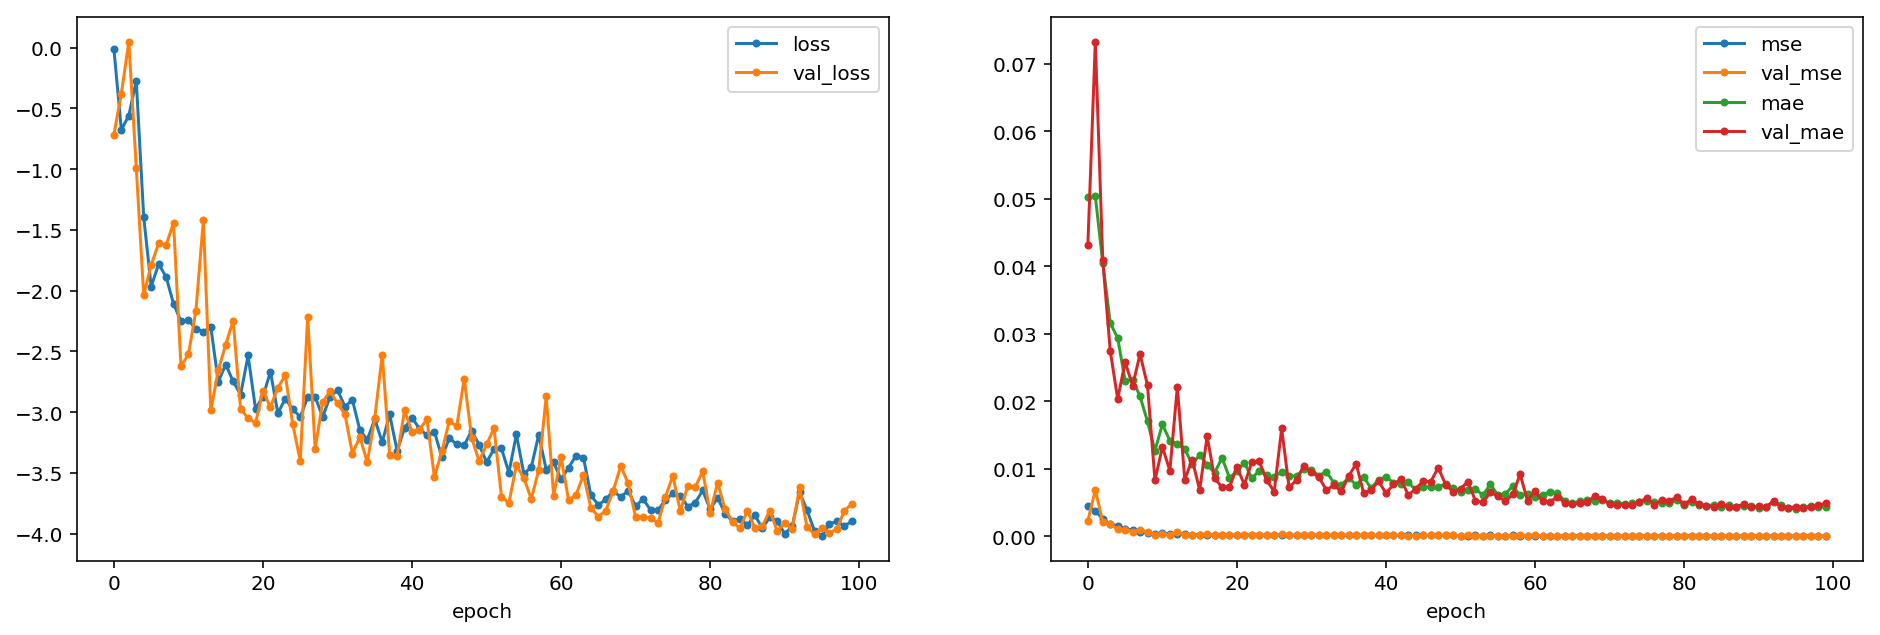

In [18]:
print(sorted(list(hn_history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

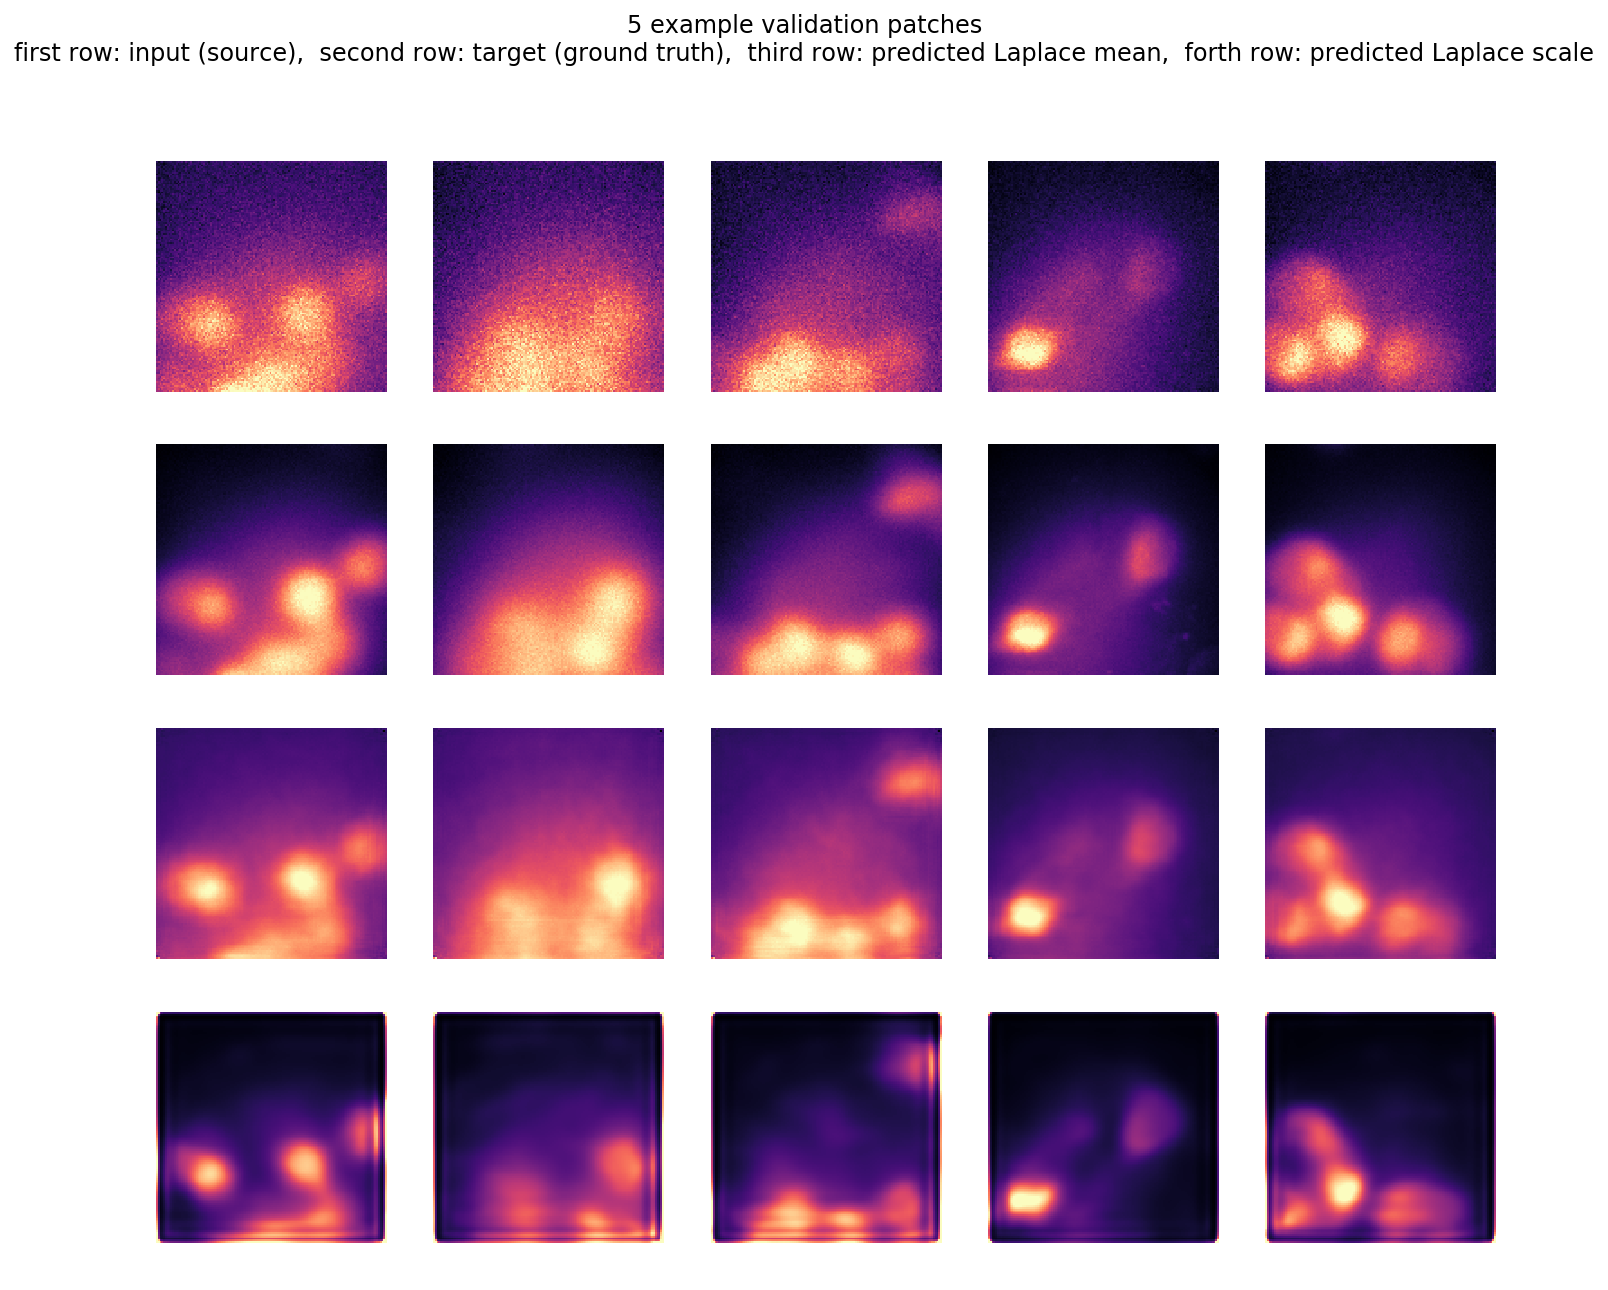

In [19]:
plt.figure(figsize=(12,10))
_P = hn_model.keras_model.predict(X_VAL[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL[:5],Y_VAL[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

In [20]:
#ORIGINAL UNCHANGED DATA

#Image Axes
#X: columns, Y: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)
axes = 'SYXC'

c = axes_dict(axes)['C']
O_n_channel_in,O_n_channel_out = X.shape[c], Y.shape[c]


In [21]:
#ORIGINAL UNCHANGED DATA
#set config file
O_config = Config(axes, O_n_channel_in, O_n_channel_out, probabilistic=True, train_steps_per_epoch=30)
print(O_config)
vars(O_config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

In [22]:
#ORIGINAL UNCHANGED DATA
#create model
O_model = CARE(O_config, 'O_my_model', basedir='models')

/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /gpfs/home/hln240/models/O_my_model
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [23]:
#ORIGINAL UNCHANGED DATA
#history
O_history = O_model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
30/30 [==============================] - 32s 1s/step - loss: 195.9184 - mse: 2886131.5625 - mae: 1303.8371 - val_loss: 9.2347 - val_mse: 1245367.2839 - val_mae: 696.1145
Epoch 2/100
30/30 [==============================] - 25s 838ms/step - loss: 8.7771 - mse: 3165829.0250 - mae: 1200.4957 - val_loss: 8.6207 - val_mse: 3317057.5647 - val_mae: 1205.9646
Epoch 3/100
30/30 [==============================] - 25s 838ms/step - loss: 8.3600 - mse: 2112367.9792 - mae: 907.5060 - val_loss: 8.1057 - val_mse: 1375901.2307 - val_mae: 715.6165
Epoch 4/100
30/30 [==============================] - 25s 836ms/step - loss: 8.0661 - mse: 1140772.4167 - mae: 669.8773 - val_loss: 8.0655 - val_mse: 1344928.7471 - val_mae: 703.1519
Epoch 5/100
30/30 [==============================] - 25s 836ms/step - loss: 8.0284 - mse: 1116589.9146 - mae: 654.5375 - val_loss: 8.0114 - val_mse: 906778.6549 - val_mae: 612.1812
Epoch 6/100
30/30 [==============================] - 25s 838ms/step - loss: 8.0059 - mse:

30/30 [==============================] - 25s 835ms/step - loss: 7.5101 - mse: 317801.2382 - mae: 379.8647 - val_loss: 7.8598 - val_mse: 304236.8260 - val_mae: 365.7612
Epoch 46/100
30/30 [==============================] - 25s 837ms/step - loss: 7.5432 - mse: 333674.5625 - mae: 391.7900 - val_loss: 7.8768 - val_mse: 423282.4510 - val_mae: 416.9854
Epoch 47/100
30/30 [==============================] - 25s 838ms/step - loss: 7.4935 - mse: 317765.3641 - mae: 376.0428 - val_loss: 7.5650 - val_mse: 339338.1578 - val_mae: 387.5705
Epoch 48/100
30/30 [==============================] - 25s 839ms/step - loss: 7.5036 - mse: 312450.8859 - mae: 377.8503 - val_loss: 8.1067 - val_mse: 333414.8647 - val_mae: 374.8647
Epoch 49/100
30/30 [==============================] - 25s 838ms/step - loss: 7.4746 - mse: 303795.3307 - mae: 369.9155 - val_loss: 7.6420 - val_mse: 328952.3622 - val_mae: 377.0141
Epoch 50/100
30/30 [==============================] - 25s 838ms/step - loss: 7.4646 - mse: 294921.1432 - mae

Epoch 89/100
30/30 [==============================] - 25s 837ms/step - loss: 7.3952 - mse: 270836.5997 - mae: 345.5555 - val_loss: 7.7756 - val_mse: 291080.9833 - val_mae: 350.9241
Epoch 90/100
30/30 [==============================] - 25s 837ms/step - loss: 7.3914 - mse: 274366.7516 - mae: 345.5798 - val_loss: 7.8547 - val_mse: 290212.3103 - val_mae: 350.7590
Epoch 91/100
30/30 [==============================] - 25s 839ms/step - loss: 7.3872 - mse: 271349.0625 - mae: 345.4857 - val_loss: 7.9145 - val_mse: 280564.2474 - val_mae: 345.2700
Epoch 92/100
30/30 [==============================] - 25s 839ms/step - loss: 7.3598 - mse: 258049.4917 - mae: 335.3770 - val_loss: 7.9424 - val_mse: 264043.7873 - val_mae: 343.1274

Epoch 00092: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 93/100
30/30 [==============================] - 25s 841ms/step - loss: 7.3729 - mse: 258219.2729 - mae: 338.8764 - val_loss: 7.8583 - val_mse: 266340.8650 - val_mae: 340.7933
Epoch 94/100
3

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


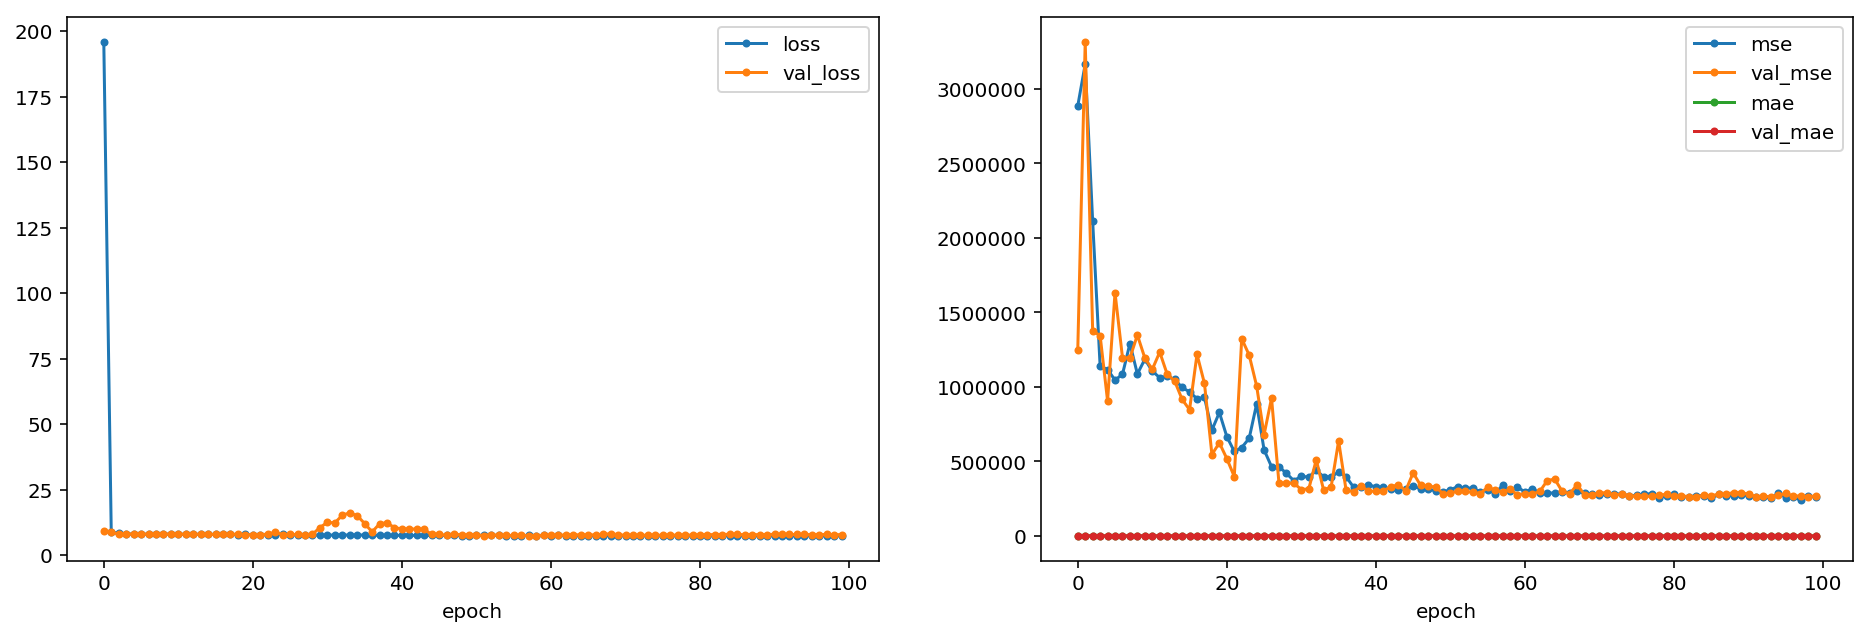

In [24]:
print(sorted(list(O_history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(O_history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

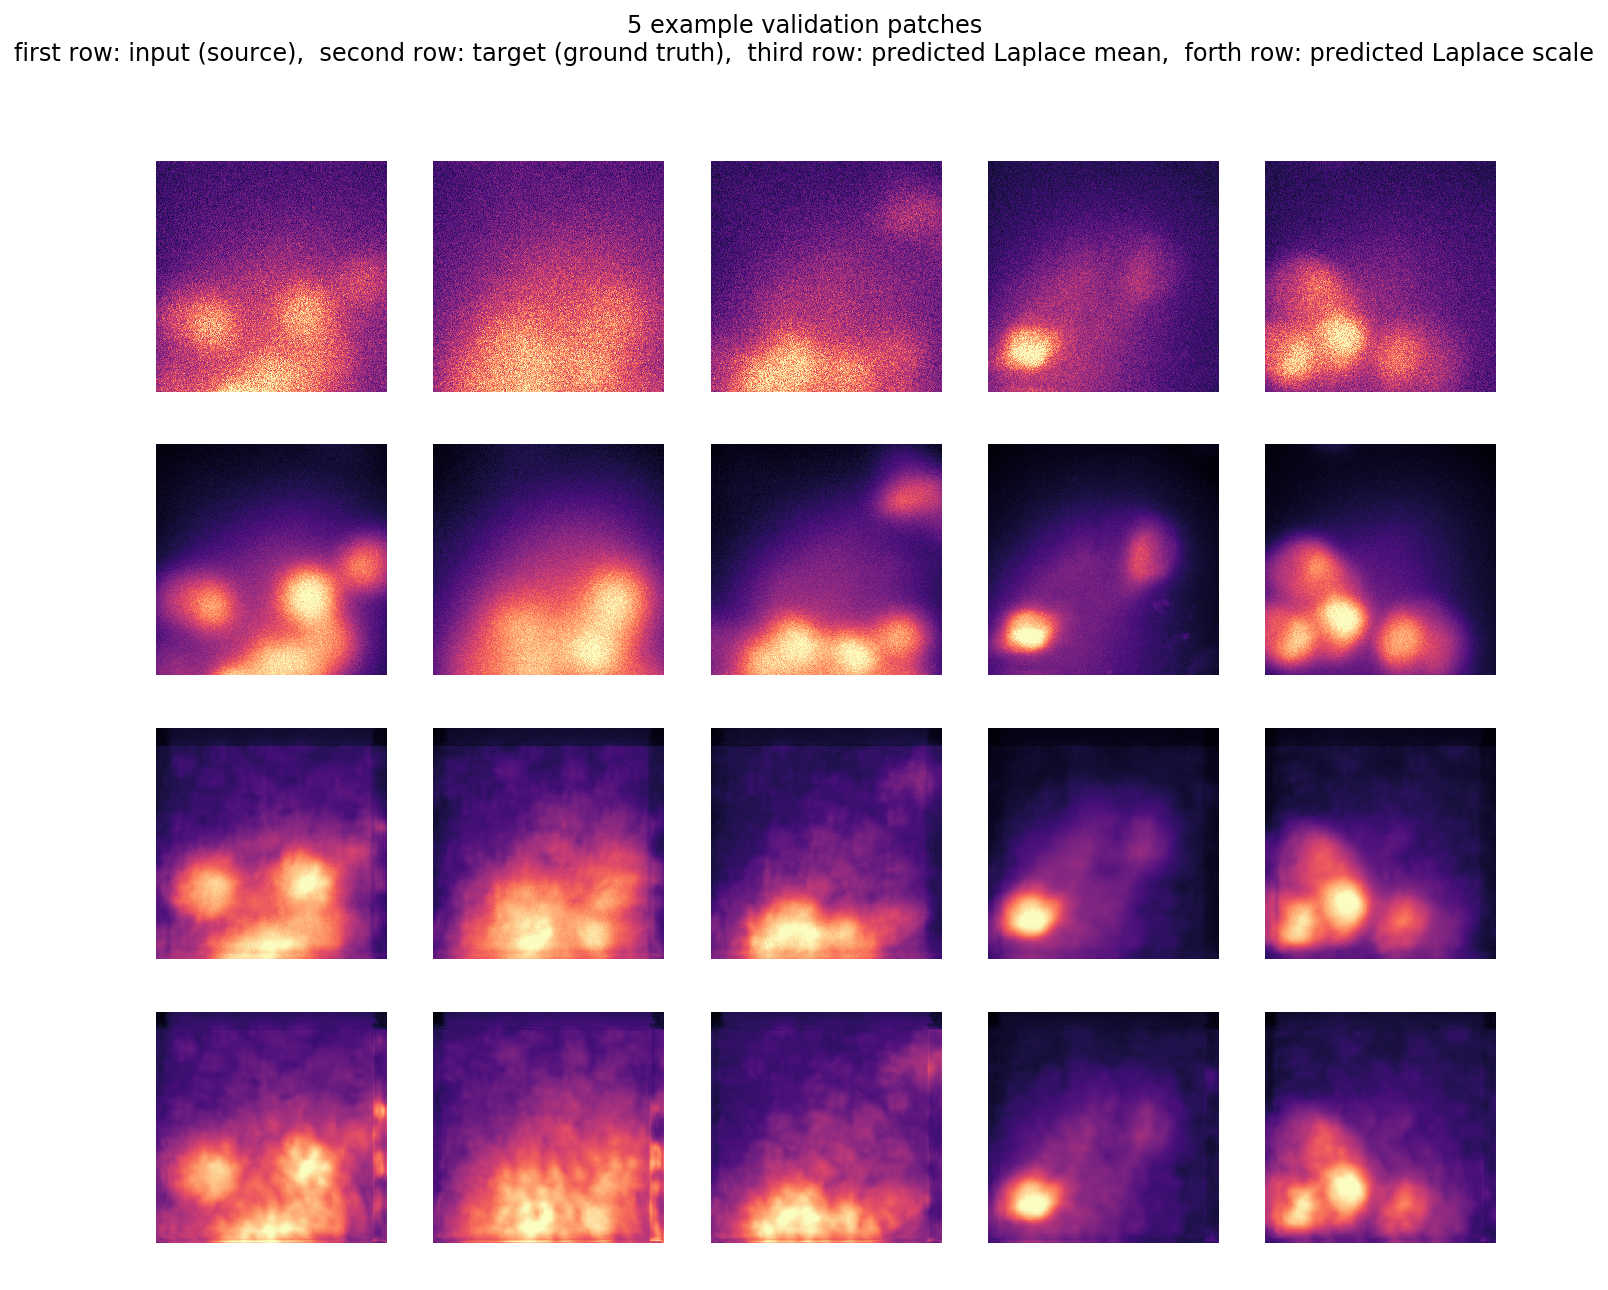

In [25]:
plt.figure(figsize=(12,10))
_P = O_model.keras_model.predict(X_val[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_val[:5],Y_val[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

## Predictions


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import CARE

Using TensorFlow backend.


In [26]:
y = Y_val[2,...,0]
x = X_val[2,...,0]
axes_ = 'YX'

image size = (512, 512)
image axes = YX


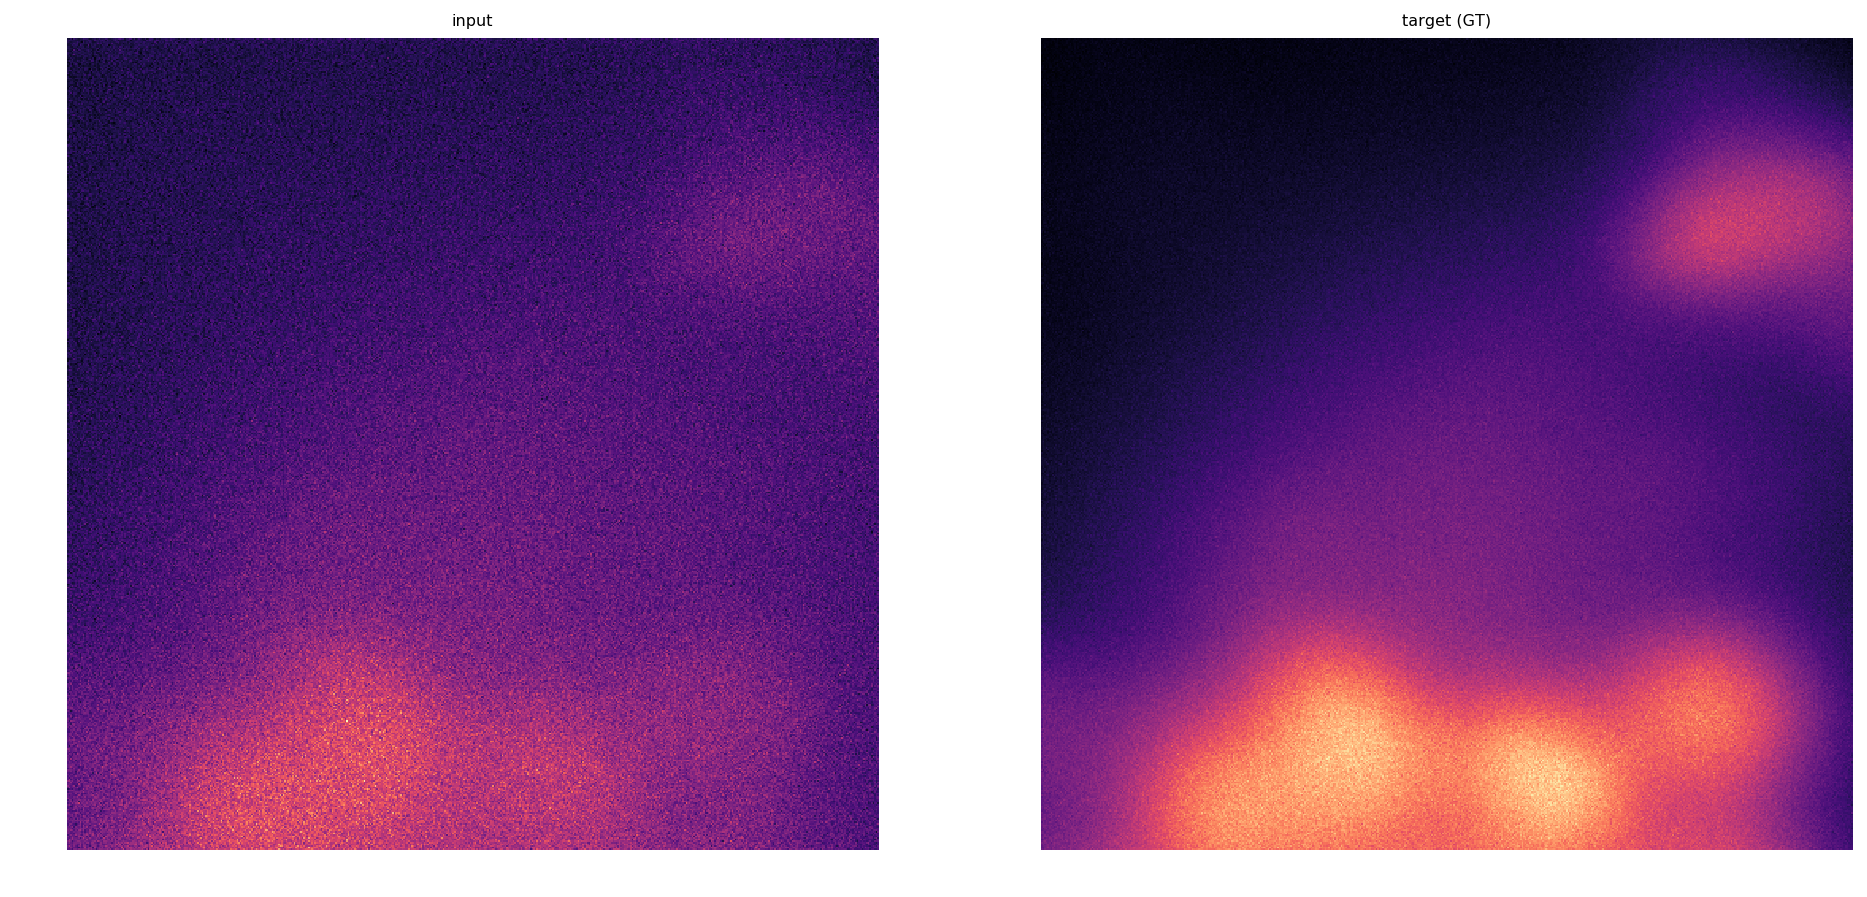

In [27]:
print('image size =', x.shape)
print('image axes =', axes_)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]), title_list=[['input','target (GT)']]);